In [1]:
import os
import sys
import glob
import pickle
import yaml
from tqdm import tqdm
import itertools


import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
sys.path.append("..")

In [3]:
import metrics
import utils

In [4]:
SAVE = False

In [40]:
results_dir = "../results/small/active"

In [45]:
config_files = glob.glob(f"{results_dir}/*/*/*.yaml")
config_files

['../results/small/active/speechbrain_2022-02-11/16-49-25/config_speechbrain_trimmed_2sec_cos_emb_avg_offline_ahc_plda_sph.yaml',
 '../results/small/active/speechbrain_2022-02-11/16-50-32/config_speechbrain_trimmed_2sec_score_cos_sc_avg.yaml',
 '../results/small/active/speechbrain_2022-02-11/16-49-42/config_speechbrain_trimmed_2sec_cos_emb_avg.yaml',
 '../results/small/active/speechbrain_2022-02-11/16-49-30/config_speechbrain_trimmed_2sec_cos_emb_avg_offline_kmeans.yaml',
 '../results/small/active/speechbrain_2022-02-11/16-49-56/config_speechbrain_trimmed_2sec_cos_emb_avg_offline_vb_plda_sph.yaml',
 '../results/small/active/speechbrain_2022-02-11/16-50-44/config_speechbrain_trimmed_2sec_cos_emb_avg_offline_label_spread.yaml',
 '../results/small/active/speechbrain_2022-02-11/16-50-57/config_speechbrain_trimmed_2sec_score_plda_sph.yaml',
 '../results/small/active/xvector_2022-02-11/16-56-47/config_xvector_trimmed_2sec_plda_diag_offline_vb_plda_sph.yaml',
 '../results/small/active/xvector

In [46]:
frr_point = 1


results_dict = {}

for config_file in tqdm(config_files):
    
    print(os.path.basename(config_file).split('.')[0])
    
    config_dir = os.path.dirname(config_file)
    config = yaml.load(open(config_file), Loader=yaml.FullLoader)
    
    embeddings_name = config["embeddings_name"] # ['clova', 'speechbrain', 'xvector']
    embeddings_type = config["embeddings_type"]

    score_type = config["score_type"] # ['cos_emb_avg', 'cos_sc_avg', 'plda_sph', 'plda_diag']
    by_the_book = config["by_the_book"] # plda scoring
    preprocessing_name = config["preprocessing_name"]
    recognizer = config["recognizer"] # ['exp_avg', 'memory'], use 'memory' for 'cos_sc_avg'
    #sequential_updates = config["sequential_updates"]
    
    params = config["params"]
    if isinstance(params, dict):
        algorithm = params.get("algorithm", ["centroid"])[0]
    else:
        algorithm = "centroid"

    #
        
    run_name = f"{embeddings_name}_{embeddings_type}_{score_type}_{algorithm}"
#     if not sequential_updates:
#         run_name = f"{run_name}_offline"
    if embeddings_name == "xvector" and by_the_book:
        run_name = f"{run_name}_by-the-book"
    print(run_name)
    
    
    FAR_known_list_noadapt = []
    FAR_unknown_list_noadapt = []
    EER_known_list_noadapt = []
    EER_unknown_list_noadapt = []
    
    
    FAR_known_list = []
    FAR_unknown_list = []
    EER_known_list = []
    EER_unknown_list = []
    
#     thresholds = []


    params_dict = {"alpha": [], "Fa": [], "Fb": [], "algorithm": [], "threshold": []}
    
    for results_dir_iter in [dir_name for dir_name in glob.glob(f"{config_dir}/*") if os.path.isdir(dir_name)]:
        #print(results_dir_iter)
        
        try:
            with open(f"{results_dir_iter}/params.pickle", "rb") as params_file:
                params = pickle.load(params_file)
            #print(params)
        except:
            print(f"Failed to load params for {results_dir_iter}")
            continue
            
            
#         thresholds += [params["threshold"]]
        
        for key in params_dict.keys():
            val = params.get(key, np.nan)
            val = val if val is not None else np.nan
            params_dict[key].append(val)
                

        try:
            scores_target_pooled = np.loadtxt(f"{results_dir_iter}/scores_tar.txt")
            scores_impostor_known_pooled = np.loadtxt(f"{results_dir_iter}/scores_imp.txt")
            scores_impostor_unknown_pooled = np.loadtxt(f"{results_dir_iter}/scores_imp_unk.txt")

            scores_target_pooled_enrich = np.loadtxt(f"{results_dir_iter}/scores_adapted_tar.txt")
            scores_impostor_known_pooled_enrich = np.loadtxt(f"{results_dir_iter}/scores_adapted_imp.txt")
            scores_impostor_unknown_pooled_enrich = np.loadtxt(f"{results_dir_iter}/scores_adapted_imp_unk.txt")
        except:
            print(f"Failed to load scores for {results_dir_iter}")
            continue
            
        # no adaptation
        scores, labels = utils.concatenate_with_labels(scores_impostor_known_pooled, scores_target_pooled)
        FAR_at_FRR_known, _ = metrics.far_at_frr(scores, labels, frr_point=frr_point)
        EER_known = metrics.eer(scores, labels)[0]*100

        scores, labels = utils.concatenate_with_labels(scores_impostor_unknown_pooled, scores_target_pooled)
        FAR_at_FRR_unknown, _ = metrics.far_at_frr(scores, labels, frr_point=frr_point)
        EER_unknown = metrics.eer(scores, labels)[0]*100
        
        FAR_known_list_noadapt += [FAR_at_FRR_known]
        FAR_unknown_list_noadapt += [FAR_at_FRR_unknown]
        EER_known_list_noadapt += [EER_known]
        EER_unknown_list_noadapt += [EER_unknown] 
        
    
        # adapted
        scores, labels = utils.concatenate_with_labels(scores_impostor_known_pooled_enrich, scores_target_pooled_enrich)
        FAR_at_FRR_known, _ = metrics.far_at_frr(scores, labels, frr_point=frr_point)
        EER_known = metrics.eer(scores, labels)[0]*100

        scores, labels = utils.concatenate_with_labels(scores_impostor_unknown_pooled_enrich, scores_target_pooled_enrich)
        FAR_at_FRR_unknown, _ = metrics.far_at_frr(scores, labels, frr_point=frr_point)
        EER_unknown = metrics.eer(scores, labels)[0]*100

        FAR_known_list += [FAR_at_FRR_known]
        FAR_unknown_list += [FAR_at_FRR_unknown]
        EER_known_list += [EER_known]
        EER_unknown_list += [EER_unknown]   
        
        
#     thresholds = np.array(thresholds)
#     alphas = np.array(alphas)

    FAR_known_list_noadapt = np.array(FAR_known_list_noadapt)
    FAR_unknown_list_noadapt = np.array(FAR_unknown_list_noadapt)
    EER_known_list_noadapt = np.array(EER_known_list_noadapt)
    EER_unknown_list_noadapt = np.array(EER_unknown_list_noadapt)
    
    FAR_known_list = np.array(FAR_known_list)
    FAR_unknown_list = np.array(FAR_unknown_list)
    EER_known_list = np.array(EER_known_list)
    EER_unknown_list = np.array(EER_unknown_list)
    
    
    results_dict_run = {}
    results_dict_run['FAR_known_noadapt'] = FAR_known_list_noadapt
    results_dict_run['FAR_unknown_noadapt'] = FAR_unknown_list_noadapt
    results_dict_run['EER_know_noadapt'] = EER_known_list_noadapt
    results_dict_run['EER_unknown_noadapt'] = EER_unknown_list_noadapt
    
    results_dict_run['FAR_known'] = FAR_known_list
    results_dict_run['FAR_unknown'] = FAR_unknown_list
    results_dict_run['EER_know'] = EER_known_list
    results_dict_run['EER_unknown'] = EER_unknown_list
    results_dict_run['params'] = params_dict
    
    for key, val in params_dict.items():
        params_dict[key] = np.array(val)
    
    
    # sort
    params_dict = results_dict_run['params']
    
    thresholds = params_dict['threshold']
    idx_sort = np.argsort(thresholds)
    
    for key, val in results_dict_run.items():
        if isinstance(val, np.ndarray):
            results_dict_run[key] = val[idx_sort]
        elif isinstance(val, dict):
            for k, v in val.items():
                if isinstance(v, np.ndarray):
                    val[k] = v[idx_sort]
                else:
                    print("Error")
                    
    results_dict[run_name] = results_dict_run


  0%|          | 0/18 [00:00<?, ?it/s]

config_speechbrain_trimmed_2sec_cos_emb_avg_offline_ahc_plda_sph
speechbrain_trimmed_2sec_plda_sph_ahc_plda_sph


  6%|▌         | 1/18 [00:00<00:08,  1.92it/s]

config_speechbrain_trimmed_2sec_score_cos_sc_avg
speechbrain_trimmed_2sec_cos_sc_avg_centroid


 11%|█         | 2/18 [00:00<00:07,  2.24it/s]

config_speechbrain_trimmed_2sec_cos_emb_avg
speechbrain_trimmed_2sec_cos_emb_avg_centroid


 17%|█▋        | 3/18 [00:02<00:12,  1.25it/s]

config_speechbrain_trimmed_2sec_cos_emb_avg_offline_kmeans
speechbrain_trimmed_2sec_cos_emb_avg_kmeans


 22%|██▏       | 4/18 [00:02<00:09,  1.55it/s]

config_speechbrain_trimmed_2sec_cos_emb_avg_offline_vb_plda_sph
speechbrain_trimmed_2sec_cos_emb_avg_vb_plda_sph


 28%|██▊       | 5/18 [00:05<00:20,  1.54s/it]

config_speechbrain_trimmed_2sec_cos_emb_avg_offline_label_spread
speechbrain_trimmed_2sec_cos_emb_avg_label_spread


 33%|███▎      | 6/18 [00:06<00:13,  1.16s/it]

config_speechbrain_trimmed_2sec_score_plda_sph
speechbrain_trimmed_2sec_plda_sph_centroid


 39%|███▉      | 7/18 [00:07<00:12,  1.14s/it]

config_xvector_trimmed_2sec_plda_diag_offline_vb_plda_sph
xvector_trimmed_2sec_plda_diag_vb_plda_diag


 44%|████▍     | 8/18 [00:10<00:19,  1.93s/it]

config_xvector_trimmed_2sec_score_plda_diag_by-the-book
xvector_trimmed_2sec_plda_diag_centroid_by-the-book


 50%|█████     | 9/18 [00:12<00:16,  1.81s/it]

config_xvector_trimmed_2sec_plda_diag_offline_kmeans
xvector_trimmed_2sec_plda_diag_kmeans


 56%|█████▌    | 10/18 [00:12<00:11,  1.39s/it]

config_xvector_trimmed_2sec_score_plda_diag
xvector_trimmed_2sec_plda_diag_centroid


 61%|██████    | 11/18 [00:14<00:10,  1.47s/it]

config_xvector_trimmed_2sec_plda_diag_offline_ahc_plda_sph
xvector_trimmed_2sec_plda_diag_ahc_plda_diag


 67%|██████▋   | 12/18 [00:15<00:08,  1.34s/it]

config_clova_2sec_cos_emb_avg_offline_vb_plda_sph
clova_2sec_cos_emb_avg_vb_plda_sph


 72%|███████▏  | 13/18 [00:19<00:11,  2.22s/it]

config_clova_2sec_score_plda_sph
clova_2sec_plda_sph_centroid


 78%|███████▊  | 14/18 [00:21<00:08,  2.16s/it]

config_clova_2sec_cos_emb_avg_offline_label_spread
clova_2sec_cos_emb_avg_label_spread


 83%|████████▎ | 15/18 [00:22<00:05,  1.68s/it]

config_clova_2sec_cos_emb_avg
clova_2sec_cos_emb_avg_centroid


 89%|████████▉ | 16/18 [00:23<00:03,  1.62s/it]

config_clova_2sec_score_cos_sc_avg
clova_2sec_cos_sc_avg_centroid


 94%|█████████▍| 17/18 [00:24<00:01,  1.29s/it]

config_clova_2sec_cos_emb_avg_offline_kmeans
clova_2sec_cos_emb_avg_kmeans


100%|██████████| 18/18 [00:24<00:00,  1.38s/it]


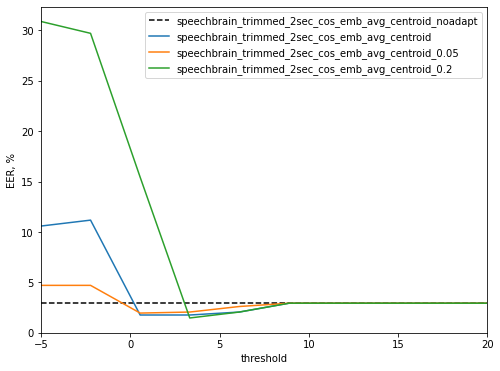

In [50]:
plt.figure(figsize=(8, 6))
plt.xlabel("threshold")
plt.ylabel("EER, %")
plt.xlim(-5, 20)


for run_name in ['speechbrain_trimmed_2sec_cos_emb_avg_centroid']: 
    
    results_dict_run = results_dict[run_name]
    params_dict = results_dict_run['params']
    
    thresholds = params_dict['threshold']
    alphas = params_dict['alpha']
    
    # w/o adaptation
    FAR_known_noadapt = results_dict_run['FAR_known_noadapt']
    FAR_unknown_noadapt = results_dict_run['FAR_unknown_noadapt']
    EER_known_noadapt = results_dict_run['EER_know_noadapt']
    EER_unknown_noadapt = results_dict_run['EER_unknown_noadapt']
    
    label = f"{run_name}_noadapt"
    plt.plot(thresholds[:], EER_known_noadapt[:], "k--", label=label);
    plt.legend()
    
    
    # w/ adaptation
    FAR_known = results_dict_run['FAR_known']
    FAR_unknown = results_dict_run['FAR_unknown']
    EER_known = results_dict_run['EER_know']
    EER_unknown = results_dict_run['EER_unknown']
    
    mask_nan = np.isnan(alphas)
    mask_num = np.logical_not(mask_nan)
    
    label = run_name
    plt.plot(thresholds[mask_nan], EER_known[mask_nan], label=label);
    plt.legend() 
    
    alpha_unique = np.unique([a for a in alphas[mask_num]])
    for i, alpha in enumerate(alpha_unique):
        mask = alphas == alpha
  
        label = f"{run_name}_{alpha}"  
        plt.plot(thresholds[mask], EER_known[mask], label=label);
        plt.legend()    
    
#plt.savefig("NAME", bbox_inches="tight") 

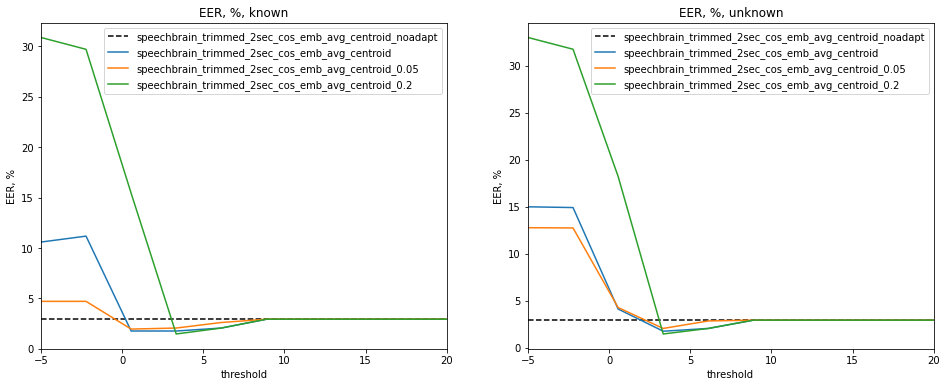

In [53]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(1, 2)
ax[0].set(xlabel="threshold", ylabel="EER, %")
ax[1].set(xlabel="threshold", ylabel="EER, %")
ax[0].set(xlim=(-5, 20))
ax[1].set(xlim=(-5, 20))
ax[0].set_title("EER, %, known")
ax[1].set_title("EER, %, unknown")


run_name = 'speechbrain_trimmed_2sec_cos_emb_avg_centroid'

results_dict_run = results_dict[run_name]
params_dict = results_dict_run['params']

thresholds = params_dict['threshold']
alphas = params_dict['alpha']

# w/o adaptation
FAR_known_noadapt = results_dict_run['FAR_known_noadapt']
FAR_unknown_noadapt = results_dict_run['FAR_unknown_noadapt']
EER_known_noadapt = results_dict_run['EER_know_noadapt']
EER_unknown_noadapt = results_dict_run['EER_unknown_noadapt']

label = f"{run_name}_noadapt"
ax[0].plot(thresholds[:], EER_known_noadapt[:], "k--", label=label);
ax[0].legend()
ax[1].plot(thresholds[:], EER_unknown_noadapt[:], "k--", label=label);
ax[1].legend()    
    

# w/ adaptation
FAR_known = results_dict_run['FAR_known']
FAR_unknown = results_dict_run['FAR_unknown']
EER_known = results_dict_run['EER_know']
EER_unknown = results_dict_run['EER_unknown']

mask_nan = np.isnan(alphas)
mask_num = np.logical_not(mask_nan)

label = run_name
ax[0].plot(thresholds[mask_nan], EER_known[mask_nan], label=label);
ax[0].legend() 

ax[1].plot(thresholds[mask_nan], EER_unknown[mask_nan], label=label);
ax[1].legend() 

alpha_unique = np.unique([a for a in alphas[mask_num]])
for i, alpha in enumerate(alpha_unique):
    mask = alphas == alpha

    label = f"{run_name}_{alpha}"  


    ax[0].plot(thresholds[mask], EER_known[mask], label=label);
    ax[0].legend()  
    
    ax[1].plot(thresholds[mask], EER_unknown[mask], label=label);
    ax[1].legend() 
    
#plt.savefig("NAME", bbox_inches="tight")

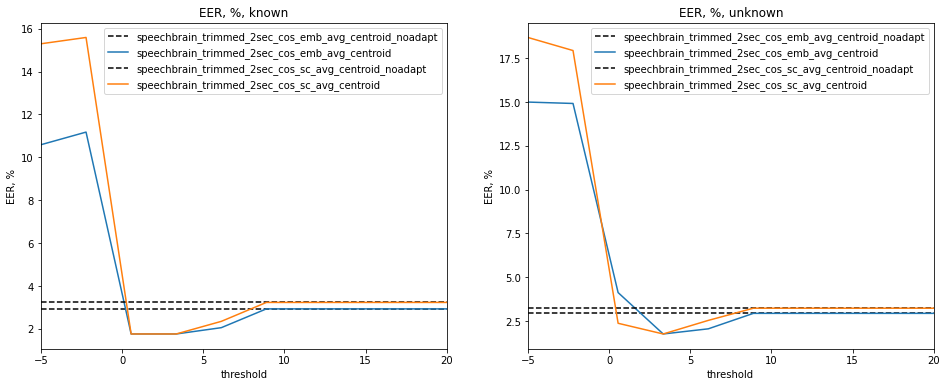

In [54]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(1, 2)
ax[0].set(xlabel="threshold", ylabel="EER, %")
ax[1].set(xlabel="threshold", ylabel="EER, %")
ax[0].set(xlim=(-5, 20))
ax[1].set(xlim=(-5, 20))
ax[0].set_title("EER, %, known")
ax[1].set_title("EER, %, unknown")


for run_name in ['speechbrain_trimmed_2sec_cos_emb_avg_centroid', 'speechbrain_trimmed_2sec_cos_sc_avg_centroid']:

    results_dict_run = results_dict[run_name]
    params_dict = results_dict_run['params']
    
    thresholds = params_dict['threshold']
    alphas = params_dict['alpha']
    
    
    # w/o adaptation
    FAR_known_noadapt = results_dict_run['FAR_known_noadapt']
    FAR_unknown_noadapt = results_dict_run['FAR_unknown_noadapt']
    EER_known_noadapt = results_dict_run['EER_know_noadapt']
    EER_unknown_noadapt = results_dict_run['EER_unknown_noadapt']

    label = f"{run_name}_noadapt"
    ax[0].plot(thresholds[:], EER_known_noadapt[:], "k--", label=label);
    ax[0].legend()
    ax[1].plot(thresholds[:], EER_unknown_noadapt[:], "k--", label=label);
    ax[1].legend()    


    # w/ adaptation                
    FAR_known = results_dict_run['FAR_known']
    FAR_unknown = results_dict_run['FAR_unknown']
    EER_known = results_dict_run['EER_know']
    EER_unknown = results_dict_run['EER_unknown']


    mask_nan = np.isnan(alphas)
    mask_num = np.logical_not(mask_nan)

    label = run_name
    ax[0].plot(thresholds[mask_nan], EER_known[mask_nan], label=label);
    ax[0].legend() 

    ax[1].plot(thresholds[mask_nan], EER_unknown[mask_nan], label=label);
    ax[1].legend() 


#plt.savefig("NAME", bbox_inches="tight")

In [23]:
results_dict.keys()

dict_keys(['speechbrain_trimmed_2sec_plda_sph_ahc_plda_sph', 'speechbrain_trimmed_2sec_cos_sc_avg_centroid', 'speechbrain_trimmed_2sec_cos_emb_avg_centroid', 'speechbrain_trimmed_2sec_cos_emb_avg_kmeans', 'speechbrain_trimmed_2sec_cos_emb_avg_vb_plda_sph', 'speechbrain_trimmed_2sec_cos_emb_avg_label_spread', 'speechbrain_trimmed_2sec_plda_sph_centroid', 'xvector_trimmed_2sec_plda_diag_vb_plda_diag', 'xvector_trimmed_2sec_plda_diag_centroid_by-the-book', 'xvector_trimmed_2sec_plda_diag_kmeans'])

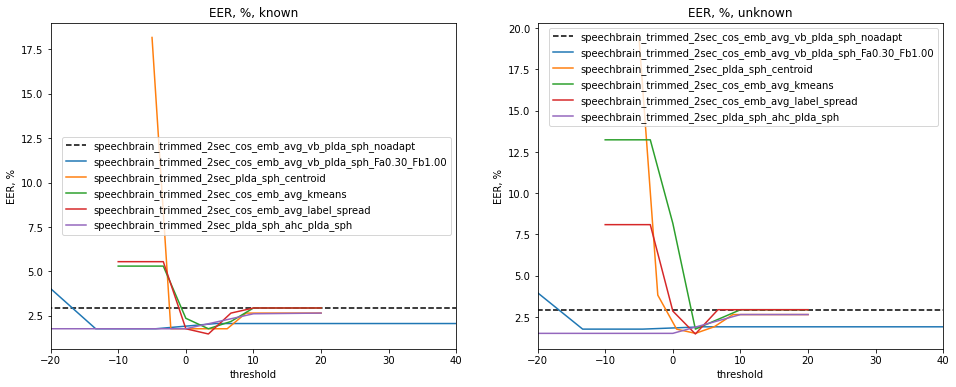

In [55]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(1, 2)
ax[0].set(xlabel="threshold", ylabel="EER, %")
ax[1].set(xlabel="threshold", ylabel="EER, %")
ax[0].set(xlim=(-20, 40))
ax[1].set(xlim=(-20, 40))
ax[0].set_title("EER, %, known")
ax[1].set_title("EER, %, unknown")



fa = 0.3
fb = 1

run_name = 'speechbrain_trimmed_2sec_cos_emb_avg_vb_plda_sph'
    
results_dict_run = results_dict[run_name]
params_dict = results_dict_run['params']
Fa = params_dict["Fa"]
Fb = params_dict["Fb"]

mask = (Fa == fa) * (Fb == fb)

thresholds = params_dict['threshold']
alphas = params_dict['alpha']

# w/o adaptation
FAR_known_noadapt = results_dict_run['FAR_known_noadapt']
FAR_unknown_noadapt = results_dict_run['FAR_unknown_noadapt']
EER_known_noadapt = results_dict_run['EER_know_noadapt']
EER_unknown_noadapt = results_dict_run['EER_unknown_noadapt']

label = f"{run_name}_noadapt"
ax[0].plot(thresholds[:], EER_known_noadapt[:], "k--", label=label);
ax[0].legend()
ax[1].plot(thresholds[:], EER_unknown_noadapt[:], "k--", label=label);
ax[1].legend()    
    

# w/ adaptation
FAR_known = results_dict_run['FAR_known']
FAR_unknown = results_dict_run['FAR_unknown']
EER_known = results_dict_run['EER_know']
EER_unknown = results_dict_run['EER_unknown']


mask_nan = np.isnan(alphas)
mask_num = np.logical_not(mask_nan)

label = f"{run_name}_Fa{fa:.2f}_Fb{fb:.2f}"

ax[0].plot(thresholds[mask], EER_known[mask], label=label);
ax[0].legend() 

ax[1].plot(thresholds[mask], EER_unknown[mask], label=label);
ax[1].legend() 




for run_name in ['speechbrain_trimmed_2sec_plda_sph_centroid',
                 'speechbrain_trimmed_2sec_cos_emb_avg_kmeans', 
                 'speechbrain_trimmed_2sec_cos_emb_avg_label_spread', 
                 'speechbrain_trimmed_2sec_plda_sph_ahc_plda_sph']:

    results_dict_run = results_dict[run_name]
    params_dict = results_dict_run['params']
    
    thresholds = params_dict['threshold']
    alphas = params_dict['alpha']
                
    FAR_known = results_dict_run['FAR_known']
    FAR_unknown = results_dict_run['FAR_unknown']
    EER_known = results_dict_run['EER_know']
    EER_unknown = results_dict_run['EER_unknown']


    mask_nan = np.isnan(alphas)
    mask_num = np.logical_not(mask_nan)

    label = run_name
    ax[0].plot(thresholds[mask_nan], EER_known[mask_nan], label=label);
    ax[0].legend() 

    ax[1].plot(thresholds[mask_nan], EER_unknown[mask_nan], label=label);
    ax[1].legend() 


In [43]:
results_dict.keys()

dict_keys(['speechbrain_trimmed_2sec_plda_sph_ahc_plda_sph', 'speechbrain_trimmed_2sec_cos_sc_avg_centroid', 'speechbrain_trimmed_2sec_cos_emb_avg_centroid', 'speechbrain_trimmed_2sec_cos_emb_avg_kmeans', 'speechbrain_trimmed_2sec_cos_emb_avg_vb_plda_sph', 'speechbrain_trimmed_2sec_cos_emb_avg_label_spread', 'speechbrain_trimmed_2sec_plda_sph_centroid', 'xvector_trimmed_2sec_plda_diag_vb_plda_diag', 'xvector_trimmed_2sec_plda_diag_centroid_by-the-book', 'xvector_trimmed_2sec_plda_diag_kmeans', 'xvector_trimmed_2sec_plda_diag_centroid', 'xvector_trimmed_2sec_plda_diag_ahc_plda_diag', 'clova_2sec_cos_emb_avg_vb_plda_sph', 'clova_2sec_plda_sph_centroid', 'clova_2sec_cos_emb_avg_label_spread', 'clova_2sec_cos_emb_avg_centroid', 'clova_2sec_cos_sc_avg_centroid', 'clova_2sec_cos_emb_avg_kmeans'])

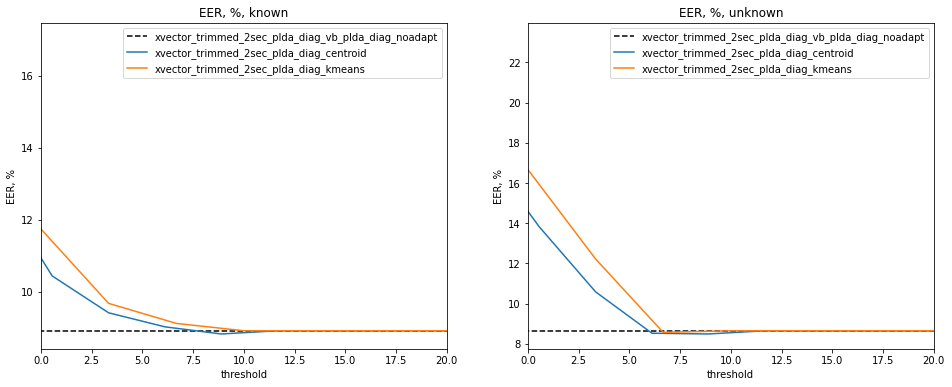

In [62]:
fig = plt.figure(figsize=(16, 6))
ax = fig.subplots(1, 2)
ax[0].set(xlabel="threshold", ylabel="EER, %")
ax[1].set(xlabel="threshold", ylabel="EER, %")
ax[0].set(xlim=(-0, 20))
ax[1].set(xlim=(-0, 20))
ax[0].set_title("EER, %, known")
ax[1].set_title("EER, %, unknown")




fa = 0.3
fb = 1

run_name = 'xvector_trimmed_2sec_plda_diag_vb_plda_diag'
    
results_dict_run = results_dict[run_name]
params_dict = results_dict_run['params']
Fa = params_dict["Fa"]
Fb = params_dict["Fb"]

mask = (Fa == fa) * (Fb == fb)

thresholds = params_dict['threshold']
alphas = params_dict['alpha']

# w/o adaptation
FAR_known_noadapt = results_dict_run['FAR_known_noadapt']
FAR_unknown_noadapt = results_dict_run['FAR_unknown_noadapt']
EER_known_noadapt = results_dict_run['EER_know_noadapt']
EER_unknown_noadapt = results_dict_run['EER_unknown_noadapt']

label = f"{run_name}_noadapt"
ax[0].plot(thresholds[:], EER_known_noadapt[:], "k--", label=label);
ax[0].legend()
ax[1].plot(thresholds[:], EER_unknown_noadapt[:], "k--", label=label);
ax[1].legend()    


# w/ adaptation
if False:
    
    FAR_known = results_dict_run['FAR_known']
    FAR_unknown = results_dict_run['FAR_unknown']
    EER_known = results_dict_run['EER_know']
    EER_unknown = results_dict_run['EER_unknown']


    mask_nan = np.isnan(alphas)
    mask_num = np.logical_not(mask_nan)

    label = f"{run_name}_Fa{fa:.2f}_Fb{fb:.2f}"

    ax[0].plot(thresholds[mask], EER_known[mask], label=label);
    ax[0].legend() 

    ax[1].plot(thresholds[mask], EER_unknown[mask], label=label);
    ax[1].legend() 




# for run_name in ['xvector_trimmed_2sec_plda_diag_centroid', 
#                  'xvector_trimmed_2sec_plda_diag_centroid_by-the-book', 
#                  'xvector_trimmed_2sec_plda_diag_kmeans', 
#                  'xvector_trimmed_2sec_plda_diag_ahc_plda_diag']:
    
for run_name in ['xvector_trimmed_2sec_plda_diag_centroid',  
                 'xvector_trimmed_2sec_plda_diag_kmeans']:

    results_dict_run = results_dict[run_name]
    params_dict = results_dict_run['params']
    
    thresholds = params_dict['threshold']
    alphas = params_dict['alpha']
                
    FAR_known = results_dict_run['FAR_known']
    FAR_unknown = results_dict_run['FAR_unknown']
    EER_known = results_dict_run['EER_know']
    EER_unknown = results_dict_run['EER_unknown']


    mask_nan = np.isnan(alphas)
    mask_num = np.logical_not(mask_nan)

    label = run_name
    ax[0].plot(thresholds[mask_nan], EER_known[mask_nan], label=label);
    ax[0].legend() 

    ax[1].plot(thresholds[mask_nan], EER_unknown[mask_nan], label=label);
    ax[1].legend() 
